### Spam Prediction with Tree-Based Models
* Team: Jonathan Tan, Lance Dacy, Reannan Mcdaniel, Shawn Jung
* Last Update: 6/7/2020
* We will build and evaluate a tree-based Random Forest model to predict 'spam'

In [1]:
# load required libraries 
import pandas as pd 
import time
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pyreadr
sns.set()
%matplotlib inline 

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# load model selection/metric related library 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.utils import resample
from sklearn.preprocessing import OrdinalEncoder

In [3]:
# Read Rda file, get the key and load as Pandas DF
result = pyreadr.read_r('data.Rda')
print(result.keys())

odict_keys(['emailDFrp'])


In [4]:
pd.set_option('display.max_columns', None)
df = result["emailDFrp"]
df.head()

,isSpam,isRe,underscore,priority,isInReplyTo,sortedRec,subPunc,multipartText,hasImages,isPGPsigned,subSpamWords,noHost,numEnd,isYelling,isOrigMsg,isDear,isWrote,numLines,bodyCharCt,subExcCt,subQuesCt,numAtt,numRec,perCaps,hour,perHTML,subBlanks,forwards,avgWordLen,numDlr
0,F,T,F,F,T,T,F,F,F,F,F,F,F,F,F,F,F,50,1554,0,0,0.0,2,4.451039,11.0,0.0,12.500000,0.000000,4.376623,3
1,F,F,F,F,F,T,F,F,F,F,F,F,F,F,F,F,F,26,873,0,0,0.0,1,7.491289,11.0,0.0,8.000000,0.000000,4.555556,0
2,F,F,F,F,F,T,F,F,F,F,F,F,F,F,F,F,F,38,1713,0,0,0.0,1,7.436096,12.0,0.0,8.000000,0.000000,4.817164,0
3,F,F,F,F,F,T,F,F,F,F,F,F,F,F,F,F,F,32,1095,0,0,0.0,0,5.090909,13.0,0.0,18.918919,3.125000,4.714286,0
4,F,T,F,F,F,T,F,F,F,F,F,F,F,F,F,F,F,31,1021,0,0,0.0,1,6.116643,13.0,0.0,15.217391,6.451613,4.234940,0


In [5]:
# Let's check the distribution of response variable. As we can see below, there is a slight imbalance between 'Spam' and 'Not Spam'. So we might as well evaluate the model performance with scores other than 'accuracy'. I would take 'f1-score'.  

df.groupby(by='isSpam').size()

isSpam
F    6951
T    2397
dtype: int64

Now let's impute and transform the data into numeric form <BR>
1. Fill null values as zero(p) as it makes sense. For instance, email without subject line can be regarded as 'not yelling'. We can revisit later, if the performance is not good. Maybe omit such records <BR>
2. First, index 0 to 16(isSpam ~ isWrote) seems to be T/F categorical variable. We can binary-encode them <BR>
3. Some variables are mistakenly converted as categorical(object), so we will change them back to numeric 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9348 entries, 0 to 9347
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   isSpam         9348 non-null   category
 1   isRe           9348 non-null   category
 2   underscore     9348 non-null   category
 3   priority       9348 non-null   category
 4   isInReplyTo    9348 non-null   category
 5   sortedRec      9348 non-null   category
 6   subPunc        9348 non-null   category
 7   multipartText  9348 non-null   category
 8   hasImages      9348 non-null   category
 9   isPGPsigned    9348 non-null   category
 10  subSpamWords   9341 non-null   category
 11  noHost         9347 non-null   category
 12  numEnd         9348 non-null   category
 13  isYelling      9341 non-null   category
 14  isOrigMsg      9348 non-null   category
 15  isDear         9348 non-null   category
 16  isWrote        9348 non-null   category
 17  numLines       9348 non-null   in

In [7]:
df.isnull().sum()

isSpam             0
isRe               0
underscore         0
priority           0
isInReplyTo        0
sortedRec          0
subPunc            0
multipartText      0
hasImages          0
isPGPsigned        0
subSpamWords       7
noHost             1
numEnd             0
isYelling          7
isOrigMsg          0
isDear             0
isWrote            0
numLines           0
bodyCharCt         0
subExcCt          20
subQuesCt         20
numAtt             0
numRec           282
perCaps            0
hour               0
perHTML            0
subBlanks         20
forwards           0
avgWordLen         0
numDlr             0
dtype: int64

In [9]:
# define a new dataframe, and copy 
email = df.select_dtypes(include=['object']).fillna('0').astype('int32').copy()
# add numerical variables
email = pd.concat([email, df.select_dtypes(include=['int32', 'float64']).fillna(0).copy()], axis=1)
# convert binary categories into 0-1 encoding 
email = pd.concat([email, df.select_dtypes(include=['category']).fillna('F').applymap(lambda x: 0 if (x=='F') else 1).copy()], axis=1)

#### Fitting Random Forest Model

In [10]:
# We will set a side 20% of validation data
y = email['isSpam'].values
X = email.drop('isSpam', axis=1).values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# we will iterate thee CV, and train/test split ratio will be 7:3
num_cv_iterations = 5
num_instances = len(y)
cv_object = KFold(n_splits=num_cv_iterations, random_state=42)

In [12]:
model = RandomForestClassifier()
scoring = 'f1'
param_grid = [{
    'criterion':['gini','entropy'], 
    'max_depth':[4,5,6,7,8,9,10],
    'min_samples_leaf':[2,3,4,5,6,7,8,9,10]
    }]

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=cv_object, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)    

In [13]:
# The F1 score with train dataset is:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.895701 using {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2}


In [18]:
# Let's validate with test dataset
# final model fitting 
dt_model = RandomForestClassifier(criterion=grid_result.best_params_['criterion'], max_depth=grid_result.best_params_['max_depth'], min_samples_leaf=grid_result.best_params_['min_samples_leaf']) 
dt_model.fit(X_train, y_train)

# estimate metrics 
y_hat = dt_model.predict(X_test) 
print('f1 score: ', round(f1_score(y_test, y_hat),4))
print('accuracy score: ', round(accuracy_score(y_test, y_hat),4))
print(confusion_matrix(y_test, y_hat))
print(classification_report(y_test, y_hat))

tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
print('specificity: ', round(tn / (tn+fp),4))
print('sensitivity: ', round(tp / (tp+fn),4))

f1 score:  0.9179
accuracy score:  0.9594
[[1369   23]
 [  53  425]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1392
           1       0.95      0.89      0.92       478

    accuracy                           0.96      1870
   macro avg       0.96      0.94      0.95      1870
weighted avg       0.96      0.96      0.96      1870

specificity:  0.9835
sensitivity:  0.8891


In [19]:
# ROC curve with the above model 
fpr, tpr, threshold = roc_curve(y_test, y_hat)
roc_auc = round(auc(fpr, tpr),4)

print('ROC AUC value is: ', roc_auc)

ROC AUC value is:  0.9363


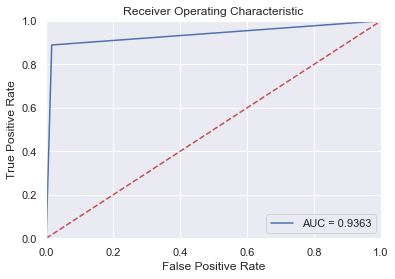

In [20]:
# Plot the ROC curve chart 
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

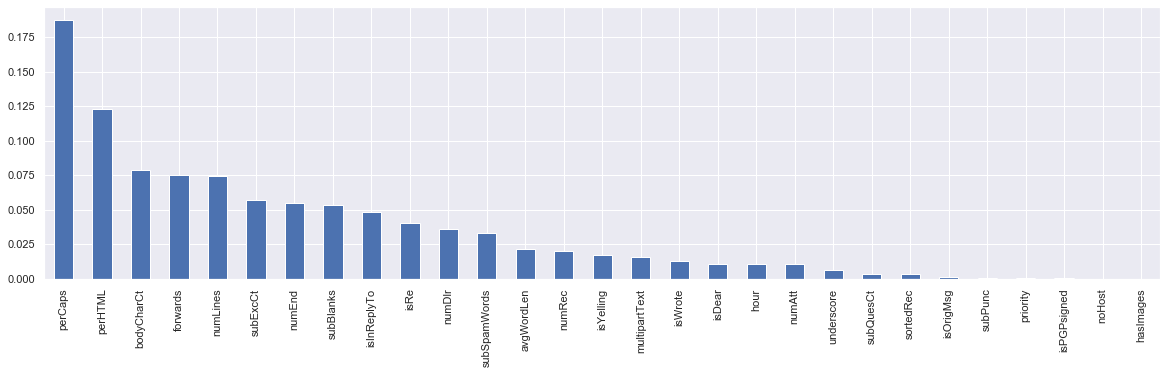

In [21]:
# Feature Importance 
plt.figure(figsize=(20,5))
weights = pd.Series(dt_model.feature_importances_, index=email.drop('isSpam', axis=1).columns).sort_values(ascending=False)
weights.plot(kind='bar')

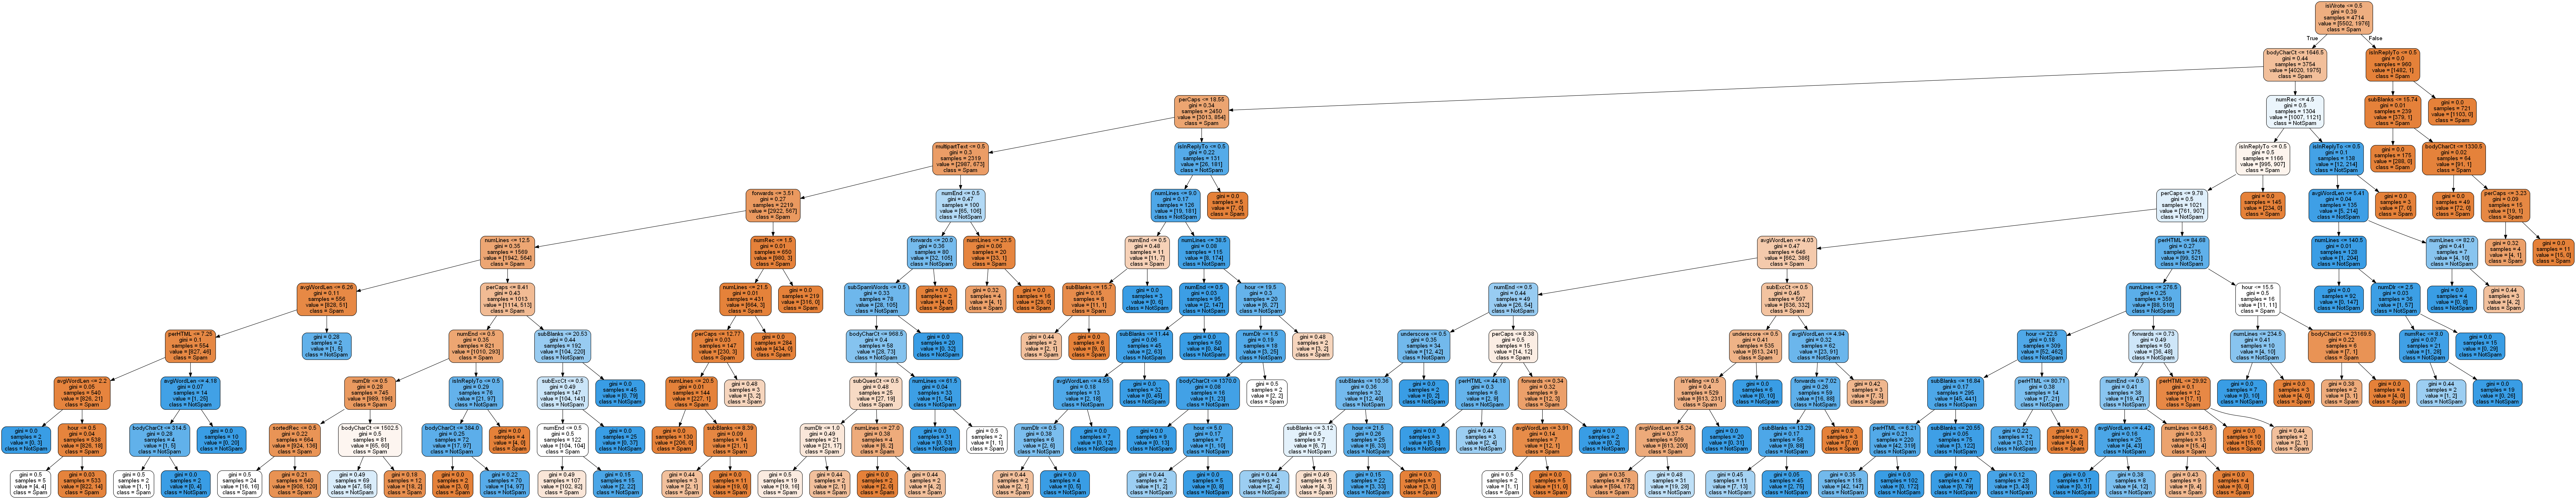

In [64]:
#viz for a single tree
rf_tree = dt_model.estimators_[1] #there are like 45? 

from sklearn.tree import export_graphviz
export_graphviz(rf_tree, 
                out_file='email_tree.dot', 
                feature_names = (email.drop('isSpam', axis=1).columns),
                class_names = (['Spam', 'NotSpam']),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

                #add graphviz executables to path
import os
#had to download graphviz in a zip from https://graphviz.gitlab.io/_pages/Download/Download_windows.html and add bin folder to path, missing something to get it to work with the python package for graphviz
os.environ["PATH"] += os.pathsep +  'D:/Downloads/Executables/graphviz-2.38/release/bin'

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi = 2000'], shell = True)

from IPython.display import Image
Image(filename = 'tree.png') #should output the png to wherever the notebook file is running